In [38]:
import pandas as pd
import numpy as np

import wrds

from dotenv import dotenv_values
config = dotenv_values(".env")

from mylib.load_from_wrds import query_options_stock, query_zero_curve
from mylib.rates_tools import create_yield_curve, merge_interest
from mylib.construct_tracer import construct_tracer
from mylib.BS_formulas import bs_delta, bs_IV

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
secid = 113993
name = "Game Stop"
ticker = "GME"

startdate = '2019-01-01'
enddate = '2022-12-31'

ALLOWED_ADJ_FACTOR_CHANGE = [0.99, 1.01]    #to filter options where adjustment factor changes over lifetime

# Download data from WRDS and do some preliminary cleaning

In [40]:
%%time

db = wrds.Connection(wrds_username=config['WRDS_USER'])

df_option = query_options_stock(db, secid, startdate=startdate, enddate=enddate)
zero_curve = query_zero_curve(db, startdate=startdate, enddate=enddate)


Loading library list...
Done
CPU times: user 5.17 s, sys: 3.17 s, total: 8.34 s
Wall time: 1min 19s


In [41]:
def query_dividend(db, secid, startdate='2019-01-01', enddate='2022-12-31'):
    query = '''
    SELECT secid, record_date, distr_type, amount, ex_date
    FROM optionm.distrd
    WHERE secid=%s
    AND ex_date BETWEEN '%s' AND '%s'
    ''' %  (secid, startdate, enddate)
    
    df = db.raw_sql(query, date_cols=['ex_date'])     
    return df

def query_stock(db, secid, startdate='2019-01-01', enddate='2022-12-31'):
    
    enddate_stock = str(int(enddate[0:4])+1) + enddate[4:]    # load one additional year
    
    query = '''
    SELECT secid, date, close, cfret
    FROM optionm.secprd
    WHERE secid=%s
    AND date BETWEEN '%s' AND '%s'
    ORDER BY date ASC
    ''' % (secid, startdate, enddate_stock)

    df = db.raw_sql(query, date_cols=['date'])
    df['adjClose'] = df['close'] * df['cfret'] / df.loc[len(df)-1]['cfret']
    return df

df_stock = query_stock(db, secid, startdate=startdate, enddate=enddate)
df_dividend = query_dividend(db, secid, startdate=startdate, enddate=enddate)

db.close()
df_dividend.head(3)

,secid,record_date,distr_type,amount,ex_date
0,113993.0,2019-03-15,1,0.38,2019-03-14
1,113993.0,2022-07-18,3,0.00,2022-07-22


In [42]:
df_dividend.dtypes

secid                 float64
record_date            object
distr_type             object
amount                float64
ex_date        datetime64[ns]
dtype: object

In [43]:
db = wrds.Connection(wrds_username=config['WRDS_USER'])


Loading library list...
Done


In [44]:
    query = '''
    SELECT secid, record_date, distr_type, amount, ex_date
    FROM optionm.distrd
    WHERE (distr_type = '2') or (distr_type = '3')
    ''' 
    
    df2 = db.raw_sql(query, date_cols=['ex_date'])     

In [45]:
df2.amount.value_counts()

amount
0.0    24214
Name: count, dtype: int64

In [46]:
df_dist = pd.merge(df_stock, df_dividend.loc[df_dividend['distr_type'].isin(['2', '3']), ['distr_type', 'ex_date']], 
                   how = 'left', left_on = ['date'], right_on = ['ex_date'])

df_factor = pd.concat([ df_dist.loc[df_dist['distr_type'].shift(-1).notna()], df_dist.loc[df_dist['distr_type'].notna(), :] ]).reset_index()
df_factor['splitfactor'] = df_factor['cfret']
df_factor['splitfactor'] = df_factor.loc[:, 'splitfactor'] / df_factor.loc[len(df_factor)-1, 'splitfactor']

In [47]:
df_dist

,secid,date,close,cfret,adjClose,distr_type,ex_date
0,113993.0,2019-01-02,13.07,2.877128,3.157909,NaN,NaT
1,113993.0,2019-01-03,12.97,2.877128,3.133747,NaN,NaT
2,113993.0,2019-01-04,15.24,2.877128,3.682214,NaN,NaT
3,113993.0,2019-01-07,15.48,2.877128,3.740201,NaN,NaT
4,113993.0,2019-01-08,15.81,2.877128,3.819934,NaN,NaT
...,...,...,...,...,...,...,...
1042,113993.0,2023-02-22,20.52,11.907900,20.520000,NaN,NaT
1043,113993.0,2023-02-23,20.14,11.907900,20.140000,NaN,NaT
1044,113993.0,2023-02-24,19.54,11.907900,19.540000,NaN,NaT
1045,113993.0,2023-02-27,19.10,11.907900,19.100000,NaN,NaT


In [48]:
df_factor

,index,secid,date,close,cfret,adjClose,distr_type,ex_date,splitfactor
0,894,113993.0,2022-07-21,153.47,2.976974,38.367487,NaN,NaT,0.25
1,895,113993.0,2022-07-22,35.78,11.907900,35.780000,3,2022-07-22,1.00


In [49]:
df_option_adj = pd.merge(df_option, df_factor[['date', 'splitfactor']], how = 'left', on = ['date']).sort_values(['date', 'exdate','cp_flag','K'])
df_option_adj['splitfactor'] = df_option_adj['splitfactor'].ffill().bfill()
df_option_adj['S0_adj'] = df_option_adj['S0'] * df_option_adj['splitfactor']
df_option_adj['K_adj'] = df_option_adj['K'] * df_option_adj['splitfactor']
df_option_adj['V0_adj'] = df_option_adj['V0'] * df_option_adj['splitfactor']
df_option_adj['adj_fac2'] = df_option_adj['adj_fac1'] / df_option_adj['splitfactor']
df_option_adj['adj_fac2'] = df_option_adj['adj_fac2'].div(df_option_adj['adj_fac2'].iloc[-1])


pd.set_option('display.max_columns', None)
df_option_adj

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,adj_fac1,M0,open_total_interest,splitfactor,S0_adj,K_adj,V0_adj,adj_fac2
0,113993.0,126851960.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,7.0,6.025,13.07,2.877128,2.877128,1.867143,92774.0,0.25,3.267499,1.749999,1.506249,0.966461
1,113993.0,126851961.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,7.5,5.875,13.07,2.877128,2.877128,1.742667,92774.0,0.25,3.267499,1.874999,1.468750,0.966461
2,113993.0,126851962.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,8.0,4.885,13.07,2.877128,2.877128,1.633750,92774.0,0.25,3.267499,1.999999,1.221250,0.966461
3,113993.0,126851963.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,8.5,4.305,13.07,2.877128,2.877128,1.537647,92774.0,0.25,3.267499,2.124999,1.076250,0.966461
4,113993.0,126851964.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,9.0,3.305,13.07,2.877128,2.877128,1.452222,92774.0,0.25,3.267499,2.249999,0.826250,0.966461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208669,113993.0,148435241.0,2022-12-30,2023-02-17,P,1.949371,-0.947138,0.0,85.0,100.0,49,0.136111,70.0,51.675,18.46,11.907900,11.907900,0.263714,641957.0,1.00,18.460000,70.000000,51.675000,1.000000
1208670,113993.0,148435242.0,2022-12-30,2023-02-17,P,2.057024,-0.936941,0.0,123.0,100.0,49,0.136111,72.5,54.225,18.46,11.907900,11.907900,0.254621,641957.0,1.00,18.460000,72.500000,54.225000,1.000000
1208671,113993.0,148435244.0,2022-12-30,2023-02-17,P,1.993416,-0.953791,0.0,100.0,100.0,49,0.136111,75.0,56.650,18.46,11.907900,11.907900,0.246133,641957.0,1.00,18.460000,75.000000,56.650000,1.000000
1208672,113993.0,148525781.0,2022-12-30,2023-02-17,P,2.070321,-0.948266,0.0,88.0,100.0,49,0.136111,77.5,59.175,18.46,11.907900,11.907900,0.238194,641957.0,1.00,18.460000,77.500000,59.175000,1.000000


In [52]:
df_option_adj.query("((date == '2022-07-21')  or (date == '2022-07-22')) and optionid==148435174")

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,adj_fac1,M0,open_total_interest,splitfactor,S0_adj,K_adj,V0_adj,adj_fac2
1074963,113993.0,148435174.0,2022-07-21,2023-02-17,C,0.765035,0.682749,0.0,0.0,100.0,211,0.586111,140.0,41.700,153.47,2.976974,11.9079,1.096214,196222.0,0.25,38.367487,34.999988,10.424996,4.000001
1076855,113993.0,148435174.0,2022-07-22,2023-02-17,C,0.797442,0.642298,6.0,0.0,100.0,210,0.583333,35.0,9.025,35.78,11.907900,11.9079,1.022286,188288.0,1.00,35.780000,35.000000,9.025000,1.000000


<Axes: xlabel='date'>

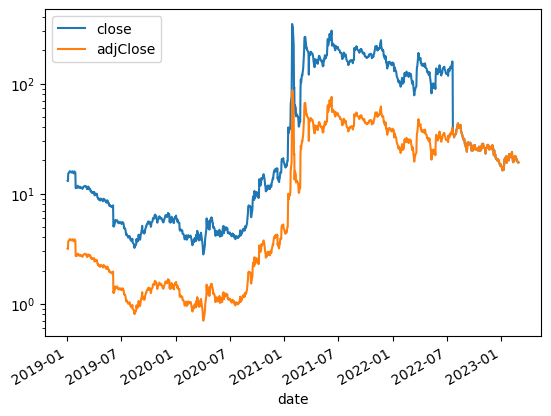

In [56]:
df_stock.set_index('date')[['close', 'adjClose']].plot(logy=True)